# EP - Classificar radiografias de pulmão em Covid-19



In [ ]:
import cv2;import matplotlib.pyplot as plt;import glob;import random
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import numpy as np;
import tensorflow.keras as keras;
import keras.backend as K; import cv2;
from tensorflow.keras import optimizers, callbacks, regularizers;
from tensorflow.keras.regularizers import l2;
from tensorflow.keras.models import Sequential, Model;
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D;
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from inspect import currentframe, getframeinfo
from tensorflow.keras.optimizers import Adam, Lion
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from typing_extensions import AsyncIterable
from tensorflow.keras.applications import EfficientNetB0

### Baixar o banco de dados do kaggle

In [ ]:
#https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
!pip3 install -q kaggle
!mkdir ~/.kaggle
!echo '{"username":"igorcostadoliveira","key":"d671763b97bcfec44bfc31f345077460"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download anasmohammedtahir/covidqu
!unzip -u covidqu.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10835).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10836).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10837).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10838).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10839).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10840).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10841).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10843).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung

### Função para ler imagens da lista wildcards

In [ ]:
def leImagens(wildcards, classes, nl, nc):
  classe = 0; i = 0
  if len(classes) == 6: n = 12205
  else: n = 21715
  AX=np.empty((n,nl,nc,1),dtype='uint8'); ay = []; # Tipo: uint8, 1 banda
  for diretorios in wildcards:
      arq = glob.glob(diretorios)
      for img in arq:
        t = image.load_img(img, color_mode='grayscale', target_size=(nl,nc))
        x = image.img_to_array(t)
        AX[i] = np.expand_dims(x, axis=0)
        ay.append(classes[classe])
        i += 1
      classe += 1
  AY = keras.utils.to_categorical(np.array(ay), 3)
  return AX, AY

In [ ]:
#Diretórios do Banco de dados
wildcards1=['./Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images/*.png']
classes1=[0, 1, 2]
wildcards2 =['./Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images/*.png']
classes2 =[0, 1, 2, 0, 1, 2]

### Classificação Manual

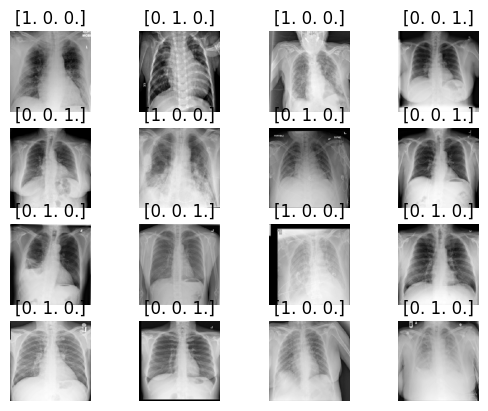

In [ ]:
axb,ayb = leImagens(wildcards1, classes1, nl=224, nc=224)
qxb,qyb = leImagens(wildcards2, classes2, nl=224, nc=224)

def mostraLote(ax, ay=None):
  for i in range(16):
      rand = random.randint(0, ax.shape[0]-1)
      plt.subplot(4, 4, i+1)
      if type(ay) != None: plt.title(f'{ay[rand]}')
      plt.imshow(ax[rand], cmap=plt.get_cmap('gray'))
      plt.axis('off')
  plt.show()
mostraLote(axb, ayb)

#### Acertei 9/16, tendo uma acurácia de 56,2%

### Modelo sem transfer learning - LENET

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 20)      520       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 20)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 40)      20040     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 40)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 112360)            0         
                                                                 
 dropout (Dropout)           (None, 112360)            0

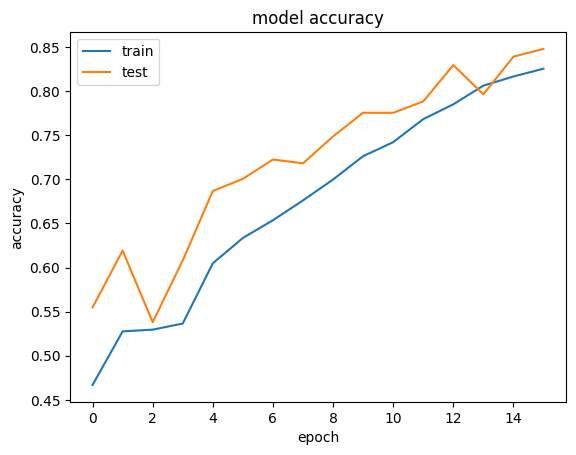

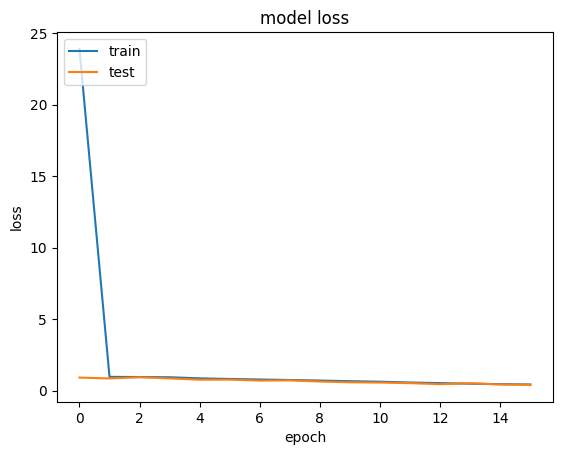

382/382 - 4s - loss: 0.4057 - accuracy: 0.8478 - 4s/epoch - 9ms/step
Test loss: 0.4056815505027771
Test accuracy: 0.8478492498397827


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Parâmetros do Modelo
batch_size = 16; epochs = 16; nl, nc = 224, 224
input_shape = (nl, nc, 1)
axb,ayb = leImagens(wildcards1, classes1, nl=nl, nc=nc)
qxb,qyb = leImagens(wildcards2, classes2, nl=nl, nc=nc)

def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def lr_schedule(epoch):
  initial_lr = 1e-3
  lr = initial_lr
  if epoch > 3:lr = initial_lr / 5
  elif epoch > 6:lr = initial_lr / 25
  elif epoch > 9:lr = initial_lr / 75
  elif epoch > 14:lr = initial_lr / 250
  print('Learning rate: ', lr)
  return lr

model = Sequential() #nx32x32x3
model.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=input_shape)) #nx28x28x20
model.add(MaxPooling2D(pool_size=(2,2))) #nx14x14x20
model.add(Conv2D(40, kernel_size=(5,5), activation='relu')) #nx10x10x40
model.add(MaxPooling2D(pool_size=(2,2))) #nx5x5x40
model.add(Flatten()) #nx1000
model.add(Dropout(0.25))
model.add(Dense(1000, activation='relu')) #nx1000
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax')) #nx10

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='ep.png', show_shapes=True)
model.summary()

opt=optimizers.Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(zoom_range=0.1)
lr_scheduler = LearningRateScheduler(lr_schedule)
history = model.fit(datagen.flow(axb, ayb, batch_size=batch_size), epochs=epochs, verbose=2, validation_data=(qxb, qyb), callbacks=[lr_scheduler])
impHistoria(history)

score = model.evaluate(qxb, qyb, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Modelo com transfer learning - EfficientNetB0

Epoch 1/8
1358/1358 [==============================] - 62s 41ms/step - loss: 0.4797 - accuracy: 0.8040 - val_loss: 0.3523 - val_accuracy: 0.8592
Epoch 2/8
1358/1358 [==============================] - 53s 39ms/step - loss: 0.3716 - accuracy: 0.8505 - val_loss: 0.3043 - val_accuracy: 0.8853
Epoch 3/8
1358/1358 [==============================] - 53s 39ms/step - loss: 0.3404 - accuracy: 0.8623 - val_loss: 0.3159 - val_accuracy: 0.8760
Epoch 4/8
1358/1358 [==============================] - 53s 39ms/step - loss: 0.3044 - accuracy: 0.8789 - val_loss: 0.2515 - val_accuracy: 0.9075
Epoch 5/8
1358/1358 [==============================] - 54s 40ms/step - loss: 0.2903 - accuracy: 0.8861 - val_loss: 0.2570 - val_accuracy: 0.9069
Epoch 6/8
1358/1358 [==============================] - 54s 40ms/step - loss: 0.2766 - accuracy: 0.8888 - val_loss: 0.2650 - val_accuracy: 0.9010
Epoch 7/8
1358/1358 [==============================] - 56s 41ms/step - loss: 0.2569 - accuracy: 0.8976 - val_loss: 0.2633 - val_ac

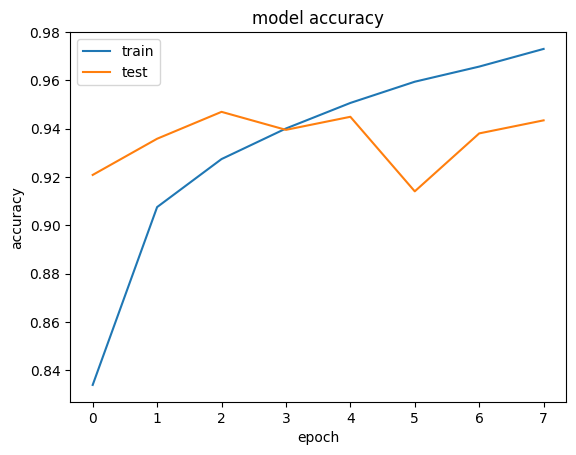

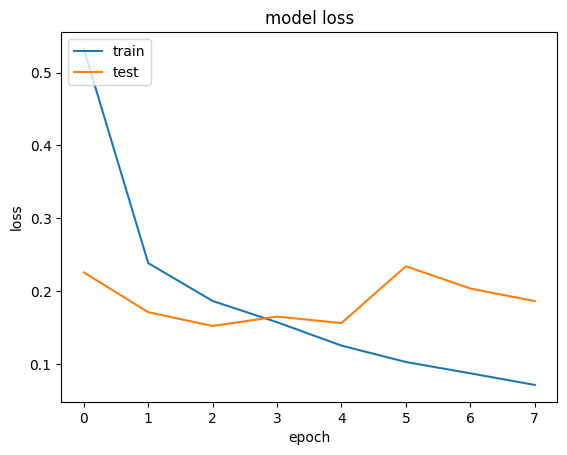

Test loss: 0.18635231256484985
Test accuracy: 0.9434657692909241


In [ ]:
axb,ayb = leImagens(wildcards1, classes1, nl=192, nc=192)
qxb,qyb = leImagens(wildcards2, classes2, nl=192, nc=192)

def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# importa o modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers: layer.trainable = False # Ajuste grosso congelado
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(axb, ayb, batch_size=16, epochs=8, validation_data=(qxb, qyb))

for layer in base_model.layers: layer.trainable = True # Ajuste fino descongelado
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(axb, ayb, batch_size=16, epochs=8, validation_data=(qxb, qyb))
impHistoria(history)

score = model.evaluate(qxb, qyb, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])